In [1]:
import os
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

base_path = './'
train_filepath = base_path + 'train.csv'
test_filepath = base_path + 'test.csv'

if os.path.exists(train_filepath):
    print('Loading data....')
    train_data = pd.read_csv(train_filepath)
    test_data = pd.read_csv(test_filepath)
    print("\n\nShow head data")
    print(train_data.head())
    print("\n\nDescribe data")
    print(train_data.describe())
    
    print("\n\nNulls in training set")
    cols_with_missing = ['{} {} nullos de {}'.format(col,train_data[col].isnull().sum(),train_data[col].isnull().count())
                         for col in train_data.columns
                         if train_data[col].isnull().any()]
    print(cols_with_missing)
    
    print("\n\nNulls in submission set")
    cols_with_missing = ['{} {} nullos de {}'.format(col,test_data[col].isnull().sum(),test_data[col].isnull().count())
                         for col in test_data.columns
                         if test_data[col].isnull().any()]
    print(cols_with_missing)
    
    print('\n\nValues of Survived in train data')
    print(train_data['Survived'].value_counts())
    
    print('\n\nSetup and Data Loaded Complete')
else:
    print('Files not exists')

Loading data....


Show head data
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            3

## Column Selection
I delete cabin column because has many null values

In [2]:
columns_to_predict =['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'] 
X_data = train_data[columns_to_predict]
y_data = train_data['Survived']
X_send_data = test_data[columns_to_predict]
X_passenger_id = test_data['PassengerId'].copy()

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=1/5,random_state=0)

print('\nX data')
print(X_data[:10])


print('\n\nY data')
print(y_data[:10])

print('\nFinished loaded...')


X data
   Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  22.0      1      0   7.2500        S
1       1  female  38.0      1      0  71.2833        C
2       3  female  26.0      0      0   7.9250        S
3       1  female  35.0      1      0  53.1000        S
4       3    male  35.0      0      0   8.0500        S
5       3    male   NaN      0      0   8.4583        Q
6       1    male  54.0      0      0  51.8625        S
7       3    male   2.0      3      1  21.0750        S
8       3  female  27.0      0      2  11.1333        S
9       2  female  14.0      1      0  30.0708        C


Y data
0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1
Name: Survived, dtype: int64

Finished loaded...


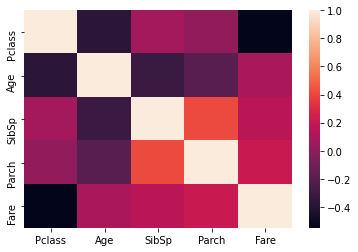

In [3]:
#Calcula la correlación entre las features, mientras más correlación, más cerca de uno está.
#Mapa de calor entre la correlación
sns.heatmap(X_data.corr())


## Column Nomalization
 I fill age with average

In [3]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
imputer = imputer.fit(X_train['Age'].values.reshape(-1, 1))

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()
X_send = X_send_data.copy()

X_train_norm['Age_was_missing'] = X_train_norm['Age'].isnull().astype(int)
X_test_norm['Age_was_missing'] = X_test_norm['Age'].isnull().astype(int)
X_send['Age_was_missing'] = X_send['Age'].isnull().astype(int)


X_train_norm.loc[:,'Age'] = imputer.transform(X_train['Age'].values.reshape(-1, 1))
X_test_norm.loc[:,'Age'] = imputer.transform(X_test['Age'].values.reshape(-1, 1))
X_send.loc[:,'Age'] = imputer.transform(X_send['Age'].values.reshape(-1, 1))



I delete 2 rows of embarked with null values


In [4]:
mask = ~pd.isnull(X_train_norm).any(axis=1)
X_train_norm = X_train_norm[mask]
y_train = y_train[mask]

mask = ~pd.isnull(X_test_norm).any(axis=1)
X_test_norm = X_test_norm[mask]
y_test = y_test[mask] 


I fill with the mean the Fare row in submission data

In [5]:
from sklearn.impute import SimpleImputer

imputerFare = SimpleImputer(missing_values=np.nan,strategy='mean')
imputerFare = imputerFare.fit(X_train['Fare'].values.reshape(-1, 1))

X_send.loc[:,'Fare'] = imputerFare.transform(X_send['Fare'].values.reshape(-1, 1))

I applied one hot encoder to sex and embarked

In [6]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
object_cols = ['Sex','Embarked']
columns = ['']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train_norm[object_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test_norm[object_cols]))
OH_cols_send = pd.DataFrame(OH_encoder.transform(X_send[object_cols]))


# One-hot encoding removed index; put it back
OH_cols_train.index = X_train_norm.index
OH_cols_test.index = X_test_norm.index
OH_cols_send.index = X_send.index


columns = []
column = ''
columns_to_drop = []
for encoder in OH_encoder.categories_:
    for column in encoder:
        columns.append('is_{}'.format(column))
    columns_to_drop.append('is_{}'.format(column))
    
OH_cols_train.columns = columns
OH_cols_test.columns = columns
OH_cols_send.columns = columns

OH_cols_train = OH_cols_train.drop(columns_to_drop,axis=1)
OH_cols_test =OH_cols_test.drop(columns_to_drop,axis=1)
OH_cols_send =OH_cols_send.drop(columns_to_drop,axis=1)

# Remove categorical columns (will replace with one-hot encoding)
num_X_train_norm = X_train_norm.drop(object_cols, axis=1)
num_X_test_norm = X_test_norm.drop(object_cols, axis=1)
num_X_send = X_send.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train_norm, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test_norm, OH_cols_test], axis=1)
OH_X_send = pd.concat([num_X_send, OH_cols_send], axis=1)

print(OH_X_train)


     Pclass        Age  SibSp  Parch     Fare  Age_was_missing  is_female  \
140       3  29.745184      0      2  15.2458                1        1.0   
439       2  31.000000      0      0  10.5000                0        0.0   
817       2  31.000000      1      1  37.0042                0        0.0   
378       3  20.000000      0      0   4.0125                0        0.0   
491       3  21.000000      0      0   7.2500                0        0.0   
..      ...        ...    ...    ...      ...              ...        ...   
835       1  39.000000      1      1  83.1583                0        1.0   
192       3  19.000000      1      0   7.8542                0        1.0   
629       3  29.745184      0      0   7.7333                1        0.0   
559       3  36.000000      1      0  17.4000                0        1.0   
684       2  60.000000      1      1  39.0000                0        0.0   

     is_C  is_Q  
140   1.0   0.0  
439   0.0   0.0  
817   1.0   0.0  
378

In [57]:
from sklearn.preprocessing import PolynomialFeatures
transformer = PolynomialFeatures(2)
#Obtiene los datos x  y x2y2 xy
X_train_poli = transformer.fit_transform(OH_X_train)
X_test_poli = transformer.transform(OH_X_test)
X_send_poli = transformer.transform(OH_X_send)

print(X_train_poli[:10])

[[1.00000000e+00 3.00000000e+00 2.97451839e+01 0.00000000e+00
  2.00000000e+00 1.52458000e+01 1.00000000e+00 1.00000000e+00
  1.00000000e+00 0.00000000e+00 9.00000000e+00 8.92355517e+01
  0.00000000e+00 6.00000000e+00 4.57374000e+01 3.00000000e+00
  3.00000000e+00 3.00000000e+00 0.00000000e+00 8.84775965e+02
  0.00000000e+00 5.94903678e+01 4.53489125e+02 2.97451839e+01
  2.97451839e+01 2.97451839e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.00000000e+00 3.04916000e+01
  2.00000000e+00 2.00000000e+00 2.00000000e+00 0.00000000e+00
  2.32434418e+02 1.52458000e+01 1.52458000e+01 1.52458000e+01
  0.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  0.00000000e+00 1.00000000e+00 1.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 2.00000000e+00 3.10000000e+01 0.00000000e+00
  0.00000000e+00 1.05000000e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.000

In [8]:
#Feature scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

X_trainf = sc_X.fit_transform(X_train_poli)
X_testf = sc_X.transform(X_test_poli)
X_sendf = sc_X.transform(X_send_poli)


print(X_trainf[:10])

print('Finished preprocessing')

[[ 0.          0.81653173  0.00437584 -0.46524741  1.95579533 -0.32893813
   2.00884569  1.37766439  2.12223372 -0.31475579]
 [ 0.         -0.38624322  0.10061282 -0.46524741 -0.47823567 -0.4236546
  -0.49779832 -0.72586619 -0.47120164 -0.31475579]
 [ 0.         -0.38624322  0.10061282  0.41094798  0.73877983  0.1053151
  -0.49779832 -0.72586619  2.12223372 -0.31475579]
 [ 0.          0.81653173 -0.74302216 -0.46524741 -0.47823567 -0.55313185
  -0.49779832 -0.72586619  2.12223372 -0.31475579]
 [ 0.          0.81653173 -0.66632807 -0.46524741 -0.47823567 -0.48851796
  -0.49779832 -0.72586619 -0.47120164 -0.31475579]
 [ 0.         -1.58901818  1.21267712 -0.46524741 -0.47823567 -0.06441137
  -0.49779832 -0.72586619 -0.47120164 -0.31475579]
 [ 0.          0.81653173 -0.58963398 -0.46524741 -0.47823567 -0.4725516
  -0.49779832 -0.72586619 -0.47120164 -0.31475579]
 [ 0.          0.81653173  0.00437584 -0.46524741 -0.47823567 -0.47596042
   2.00884569  1.37766439 -0.47120164  3.17706626]
 [ 

## Model

### Linear SVC
Selecting best model Linear SVC

In [70]:
#Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters = [
    {'penalty':['l1'],'dual':[False],'C':np.arange(0, 20, 5).tolist(),
     'max_iter':np.arange(1000,20000, 5000).tolist(),'tol':np.arange(0.0001, 0.001, 0.0001).tolist()}
]
grid_search = GridSearchCV(estimator=LinearSVC(),
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=3,
                         n_jobs=-1,
                         verbose=10)
grid_search = grid_search.fit(X_trainf,y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best accuracy {}%".format(best_accuracy*100))
print("Best pameters \n {}".format(best_parameters))

ValueError: Found input variables with inconsistent numbers of samples: [710, 569]

#### Best model Linear SVC

Position 9846

Score 0.77511

Precision 78.96%

Variance 15.81%

TRAIN

True positives 292 -
False positives 48 -
False negative 69 -
True negative 160 -


TEST

True positives 69 -
False positives 15 -
False negative 13 -
True negative 46 -

In [83]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

best_model = LinearSVC(max_iter=10000,dual=False, tol=0.0007, C=5.5,penalty='l1')
best_model.fit(X_trainf, y_train)

LinearSVC(C=5.5, dual=False, max_iter=10000, penalty='l1', tol=0.0007)

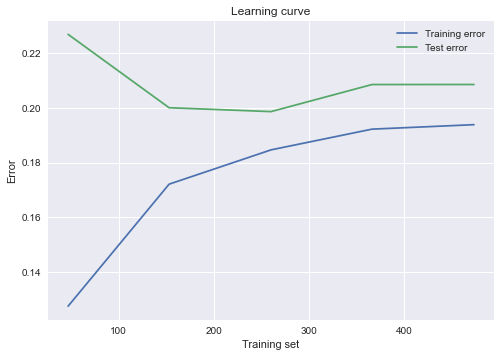

In [84]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=LinearSVC(max_iter=10000,dual=False, tol=0.0007, C=5.5,penalty='l1'),
                    X=X_trainf,
                    y=y_train,
                    scoring = 'neg_mean_squared_error',
                    cv=3,
                    n_jobs=-1)
#Gráfico la curva de aprendizaje
plt.style.use('seaborn')
plt.plot(train_sizes,-np.mean(train_scores,axis=1), label = 'Training error')
plt.plot(train_sizes,-np.mean(test_scores ,axis=1), label = 'Test error')
plt.xlabel("Training set")
plt.ylabel("Error")
plt.title("Learning curve")
plt.legend()
plt.show()

### KNeighborsClassifier

In [87]:
from sklearn.neighbors import KNeighborsClassifier
best_model = KNeighborsClassifier(n_neighbors=8,
                                  weights='uniform', 
                                  algorithm='kd_tree', 
                                  leaf_size=30,
                                  p=1, 
                                  metric='manhattan', 
                                  n_jobs=-1)
best_model.fit(X_trainf,y_train)

KNeighborsClassifier(algorithm='kd_tree', metric='manhattan', n_jobs=-1,
                     n_neighbors=8, p=1)

In [86]:
#Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters = [
    {'n_neighbors':np.arange(4, 20, 1).tolist(),
     'weights':['uniform','distance'],
     'algorithm':['ball_tree','kd_tree','brute'],
     'leaf_size': np.arange(0,100, 10).tolist(),
     'p':[1,2],
     'metric':['euclidean','manhattan','minkowski']}
]
grid_search = GridSearchCV(estimator=KNeighborsClassifier(),
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=3,
                         verbose=10,
                         n_jobs=-1)
grid_search = grid_search.fit(X_trainf,y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best accuracy {}%".format(best_accuracy*100))
print("Best pameters \n {}".format(best_parameters))

Fitting 3 folds for each of 5760 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0329s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0170s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0149s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0289s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0349s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0588s.) Setting batch_size=64.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (

Best accuracy 81.40658895325275%
Best pameters 
 {'algorithm': 'kd_tree', 'leaf_size': 30, 'metric': 'manhattan', 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}


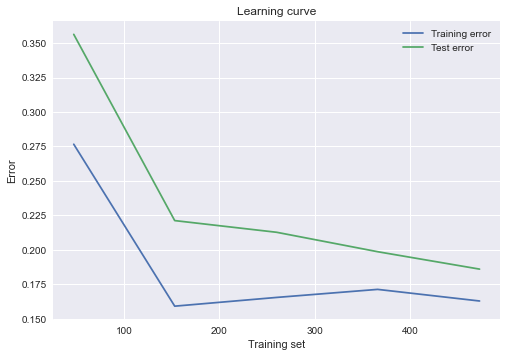

In [88]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=best_model,
                    X=X_trainf,
                    y=y_train,
                    scoring = 'neg_mean_squared_error',
                    cv=3,
                    n_jobs=-1)
#Gráfico la curva de aprendizaje
plt.style.use('seaborn')
plt.plot(train_sizes,-np.mean(train_scores,axis=1), label = 'Training error')
plt.plot(train_sizes,-np.mean(test_scores ,axis=1), label = 'Test error')
plt.xlabel("Training set")
plt.ylabel("Error")
plt.title("Learning curve")
plt.legend()
plt.show()

### XGBoost 


In [92]:
#Fitting XGBoost to the training set
from xgboost import XGBClassifier
best_model = XGBClassifier(booster='dart',
                           colsample_bytree= 0.6,
                           gamma=1.5, 
                           max_depth=5,
                           min_child_weight=1,
                           subsample= 1)
best_model.fit(X_trainf,y_train)

XGBClassifier(booster='dart', colsample_bytree=0.6, gamma=1.5, max_depth=5)

In [91]:
#Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters = [
    {'booster':['gbtree', 'gblinear', 'dart'],
     'min_child_weight': [1, 5, 10],
     'gamma': [0.5, 1, 1.5, 2, 5],
     'subsample': [0.6, 0.8, 1.0],
     'colsample_bytree': [0.6, 0.8, 1.0],
     'max_depth': [3, 4, 5]}
]
grid_search = GridSearchCV(estimator=XGBClassifier(),
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=3,
                         verbose=10,
                         n_jobs=-1)
grid_search = grid_search.fit(X_trainf,y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best accuracy {}%".format(best_accuracy*100))
print("Best pameters \n {}".format(best_parameters))

Fitting 3 folds for each of 1215 candidates, totalling 3645 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0808s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1047s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 320 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 440 tasks      | elapsed:    4.8s
[Parallel(n_jo

Best accuracy 82.95728146082148%
Best pameters 
 {'booster': 'dart', 'colsample_bytree': 0.6, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0}


[Parallel(n_jobs=-1)]: Done 3645 out of 3645 | elapsed:   44.0s finished


#### Nerural Network

In [51]:
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

#session = tf.compat.v1.keras.backend.get_session()
# Run training on GPU
def create_model():
    with tf.device('/gpu:0'):
        #Initialising the ANN
        best_model = Sequential()
        # Adding the input layer and the first hidden layer
        best_model.add(Dense(20,kernel_initializer='uniform',activation='relu',input_dim=10))
        best_model.add(Dense(20,kernel_initializer='uniform',activation='relu'))
        #Adding the second hidden layer
        # Adding the output layer
        best_model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))
        #Compiling the ANN
        best_model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
        return best_model

In [52]:
best_model = create_model()
#Fitting the ANN to the Training Set
history = best_model.fit(X_trainf,y_train,validation_split = 0.1, epochs=150, batch_size=4)
print('Training finished')

Train on 639 samples, validate on 71 samples
Epoch 1/150
639/639 [==============================] - 1s 1ms/step - loss: 0.2467 - accuracy: 0.6322 - val_loss: 0.2516 - val_accuracy: 0.4930
Epoch 2/150
639/639 [==============================] - 1s 928us/step - loss: 0.1972 - accuracy: 0.6322 - val_loss: 0.2203 - val_accuracy: 0.4930
Epoch 3/150
639/639 [==============================] - 1s 921us/step - loss: 0.1679 - accuracy: 0.7778 - val_loss: 0.1976 - val_accuracy: 0.7324
Epoch 4/150
639/639 [==============================] - 1s 913us/step - loss: 0.1517 - accuracy: 0.8216 - val_loss: 0.1736 - val_accuracy: 0.8028
Epoch 5/150
639/639 [==============================] - 1s 911us/step - loss: 0.1405 - accuracy: 0.8263 - val_loss: 0.1606 - val_accuracy: 0.8028
Epoch 6/150
639/639 [==============================] - 1s 940us/step - loss: 0.1329 - accuracy: 0.8232 - val_loss: 0.1619 - val_accuracy: 0.7746
Epoch 7/150
639/639 [==============================] - 1s 943us/step - loss: 0.1292 - a

In [54]:
print(best_model.predict(X_testf[:10]))

[[0.17523089]
 [0.10246065]
 [0.01925575]
 [0.99016786]
 [0.19848363]
 [0.14753403]
 [0.99926037]
 [0.9972523 ]
 [0.44269258]
 [0.8407068 ]]


## Test

In [53]:
from sklearn.metrics import confusion_matrix

y_predict = (best_model.predict(X_trainf)>0.5).astype(int)
cm = confusion_matrix(y_train,y_predict)
print("TRAIN\nTrue positives {} \nFalse positives {} \nFalse negative {} \nTrue negative {}\n\n".format(cm[0][0],cm[0][1],cm[1][0],cm[1][1]))

y_predict_test = (best_model.predict(X_testf)>0.5).astype(int)
cm = confusion_matrix(y_test,y_predict_test)
print("TEST\nTrue positives {} \nFalse positives {} \nFalse negative {} \nTrue negative {}\n\n".format(cm[0][0],cm[0][1],cm[1][0],cm[1][1]))


#Applying k-Flod Cross Validation
from sklearn.model_selection import cross_val_score
#accuracies = cross_val_score(estimator=best_model, X=X_trainf, y=y_train,scoring='r2', cv=100)


#print("Precision {}%".format(accuracies.mean()*100))
print("Precision {}%".format(history.history['accuracy'][len(history.history['accuracy'])-1]*100))

#Indica la varianza
#print("Variance {}%".format(accuracies.std()*100))


TRAIN
True positives 413 
False positives 26 
False negative 57 
True negative 214


TEST
True positives 96 
False positives 14 
False negative 23 
True negative 46


Precision 88.73239159584045%


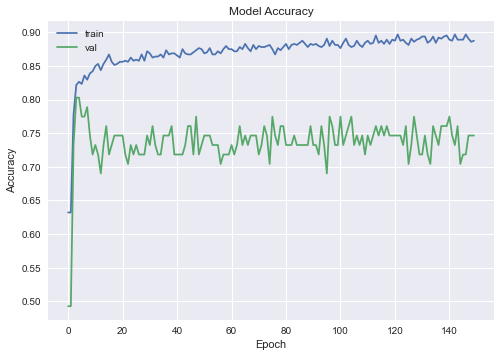

In [54]:
plt.style.use('seaborn')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

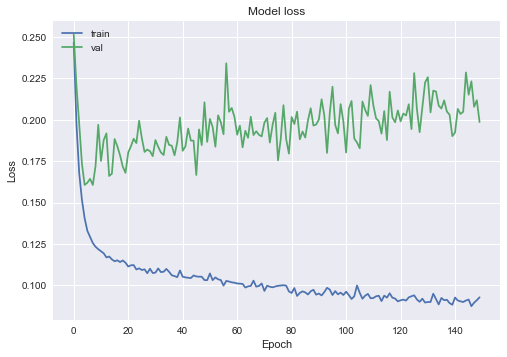

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [104]:
from sklearn.model_selection import KFold

n_split=3

for train_index,test_index in KFold(n_split).split(X_trainf):
    x_traink,x_testk=X_trainf[train_index],X_trainf[test_index]
    y_traink,y_testk=y_train.reindex(train_index),y_train.reindex(test_index)
  
    model=create_model()
    model.fit(x_traink, y_traink,epochs=20)
  
    print('Model evaluation ',model.evaluate(x_testk,y_testk))

Epoch 1/20
473/473 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.0233
Epoch 2/20
473/473 [==============================] - 0s 421us/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/20
473/473 [==============================] - 0s 376us/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/20
473/473 [==============================] - 0s 578us/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/20
473/473 [==============================] - 0s 273us/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/20
473/473 [==============================] - 0s 554us/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/20
473/473 [==============================] - 0s 423us/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/20
473/473 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0000e+0 - 0s 239us/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/20
473/473 [==============================] - 0s 203us/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/20
473/473 [==============

## Submission

In [56]:
best_model.fit(X_testf,y_test,validation_split = 0.1, epochs=150, batch_size=4)
y_send = (best_model.predict(X_sendf)>0.5).astype(int).reshape(1,-1)[0]

data = {'PassengerId': X_passenger_id,
        'Survived': y_send}
df = pd.DataFrame(data)
df.to_csv('submission.csv',index=False)


Train on 161 samples, validate on 18 samples
Epoch 1/150
161/161 [==============================] - 0s 1ms/step - loss: 0.1705 - accuracy: 0.7888 - val_loss: 0.1066 - val_accuracy: 0.8889
Epoch 2/150
161/161 [==============================] - 0s 1ms/step - loss: 0.1494 - accuracy: 0.8199 - val_loss: 0.1044 - val_accuracy: 0.8889
Epoch 3/150
161/161 [==============================] - 0s 991us/step - loss: 0.1361 - accuracy: 0.8261 - val_loss: 0.1073 - val_accuracy: 0.8889
Epoch 4/150
161/161 [==============================] - 0s 1ms/step - loss: 0.1283 - accuracy: 0.8385 - val_loss: 0.1162 - val_accuracy: 0.8333
Epoch 5/150
161/161 [==============================] - 0s 1ms/step - loss: 0.1275 - accuracy: 0.8385 - val_loss: 0.1155 - val_accuracy: 0.8889
Epoch 6/150
161/161 [==============================] - 0s 979us/step - loss: 0.1204 - accuracy: 0.8634 - val_loss: 0.1220 - val_accuracy: 0.8333
Epoch 7/150
161/161 [==============================] - 0s 991us/step - loss: 0.1195 - accurac